In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# TFlite inference

In [2]:
interpreter = tf.lite.Interpreter('face_landmarks_detector.tflite')
interpreter.allocate_tensors()

#Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

[{'name': 'input_12', 'index': 0, 'shape': array([  1, 256, 256,   3]), 'shape_signature': array([ -1, 256, 256,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 473, 'shape': array([   1,    1,    1, 1434]), 'shape_signature': array([  -1,    1,    1, 1434]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'Identity_1', 'index': 472, 'shape': array([1, 1, 1, 1]), 'shape_signature': array([-1,  1,  1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_par

Image original shape:  (218, 231, 3)


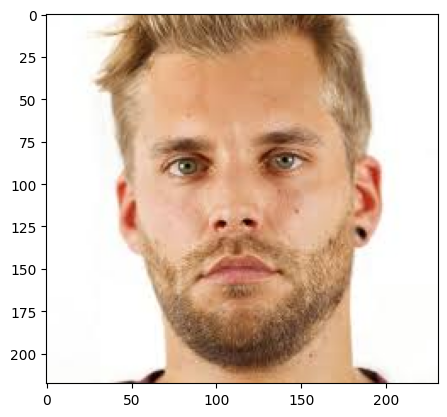

In [97]:
img = cv2.imread('face.jpg')
print('Image original shape: ', img.shape)
zC = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# rgb_img = rgb_img[:250][:]
plt.imshow(rgb_img)
plt.show()

# Resize model

In [98]:
#Test result with face image
image_size =256
#tmp = cv2.resize(rgb_img, [image_size,image_size],)
scale = 1.0
w,h = rgb_img.shape[:2]

if w>h:
    scale = image_size*1.0/w
    w = image_size
    h = h*scale
else:
    scale = image_size*1.0/h
    h = image_size
    w = w*scale

tmp = cv2.resize(rgb_img, [int(w),int(h)],)
print(tmp.shape)
wpad = image_size - int(w)
hpad = image_size - int(h)

tmp = cv2.copyMakeBorder(
    tmp,
    top= int(hpad/2),
    bottom=hpad - int(hpad/2),
    left=int(wpad/2),
    right=wpad - int(wpad/2),
    borderType=cv2.BORDER_CONSTANT,
    value=0.0
)

input_img  = tmp/127.5 -1

tensor_img = tf.constant([input_img], dtype = tf.float32)
input_blob = np.zeros((1, image_size, image_size,3),
                              dtype=np.float32)
input_blob[0] = tensor_img
input_blob.shape

(256, 241, 3)


(1, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


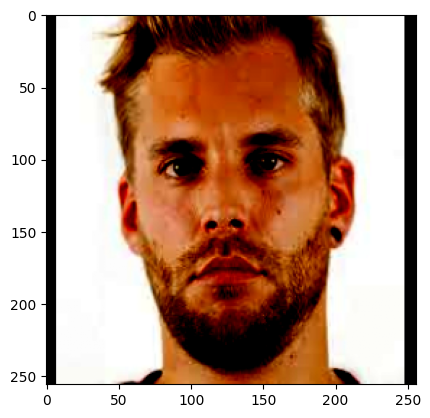

In [99]:
print(input_img.shape)
plt.imshow(input_img)
plt.show()

In [100]:
#Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_blob)
interpreter.invoke()
#Get output
output_data = interpreter.get_tensor(output_details[0]['index'])

In [101]:
out0 = output_data[0]
out0.shape

(1, 1, 1434)


# Landmark result on padded image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Facial landmark detection:  (256, 256, 3)


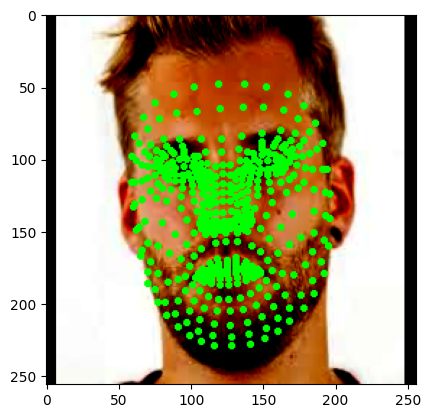

In [102]:
landmark = np.reshape(out0, [-1,3])
result = input_img.copy()
for i in range(len(landmark)):
    x,y,_ = landmark[i]
    point = (int(x),int(y))
    cv2.circle(result, point, 1, (0, 255, 0), 2)

print('Facial landmark detection: ',result.shape)
plt.imshow(result)
plt.show()

# Lanmark result on original image

Facial landmark detection:  (218, 231, 3)


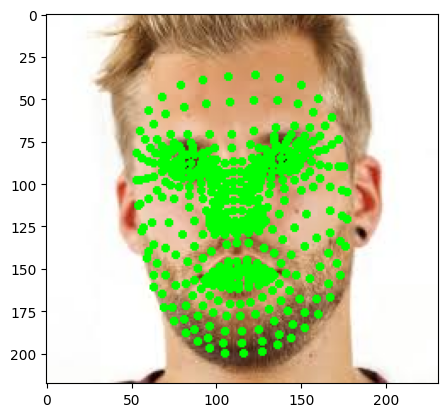

In [105]:
result = rgb_img.copy()
for i in range(len(landmark)):
    x,y,_ = landmark[i]
    p1 = (x-hpad/2)/scale
    p2 = (y-wpad/2)/scale
    point = (int(p1),int(p2))
    cv2.circle(result, point, 1, (0, 255, 0), 2)

print('Facial landmark detection: ',result.shape)
plt.imshow(result)
plt.show()

Facial landmark detection:  (218, 231, 3)


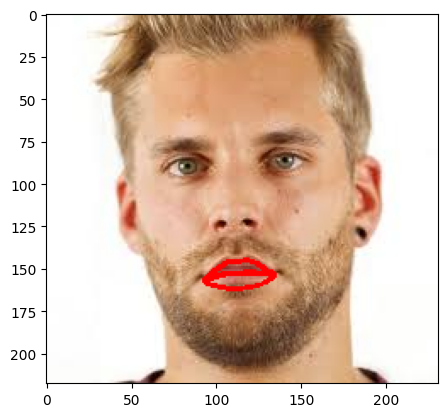

In [108]:
FACEMESH_LIPS = [[61, 146], [146, 91], [91, 181], [181, 84], [84, 17],
                 [17, 314], [314, 405], [405, 321], [321, 375],
                 [375, 291], [61, 185], [185, 40], [40, 39], [39, 37],
                 [37, 0], [0, 267],
                 [267, 269], [269, 270], [270, 409], [409, 291],
                 [78, 95], [95, 88], [88, 178], [178, 87], [87, 14],
                 [14, 317], [317, 402], [402, 318], [318, 324],
                 [324, 308], [78, 191], [191, 80], [80, 81], [81, 82],
                 [82, 13], [13, 312], [312, 311], [311, 310],
                 [310, 415], [415, 308]]

result = rgb_img.copy()
for x,y in FACEMESH_LIPS:
    p1 = landmark[x][:2].copy()
    p1[0] = (p1[0] - hpad/2)/scale
    p1[1] = (p1[1] - wpad/2)/scale
    p2 = landmark[y][:2].copy()
    p2[0] = (p2[0] - hpad/2)/scale
    p2[1] = (p2[1] - wpad/2)/scale
    cv2.line(result, p1.astype(np.int32), p2.astype(np.int32), (255,0,0),2)
    
print('Facial landmark detection: ',result.shape)
plt.imshow(result)
plt.show()